In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from phik.report import plot_correlation_matrix
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin, BaseEstimator
from IPython.display import Image
import dill as pickle
from sklearn.pipeline import Pipeline

pd.options.display.float_format = '{:.2f}'.format

В данной работе мы решаем задачу регрессии -- учимся предсказывать цену бриллианта по его физическим показателям. Имеющийся у нас датасет содержит информацию о 53940 бриллиантах. Мы используем несколько моделей -- линейную регрессию, дерево решений, случайный лес и градиентный бустинг и сравниваем их между собой.

Из датасета создаётся 3 выборки -- обучающая, валидационная и тестовая. Валидационная используется для сравнения моделей между собой, тестовая для демонстрации результатов лучшей модели.

В качестве метрики мы берём RMSE, она имеет простую интерпретацию, отношение RMSE/mean может дать нам хорошее представление о точности модели.

In [2]:
# В датасете нет пропусков, 3 категориальные переменные, остальные -- числовые.

df = pd.read_csv('diamonds.csv')
display(df.head())
df.info()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.50,55.00,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.80,61.00,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.90,65.00,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.40,58.00,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.30,58.00,335,4.34,4.35,2.75


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [3]:
# Дубликаты в данных отсутствуют
df.duplicated().sum()

0

In [4]:
# Unnamed: 0 представляет собой индекс, который нам не нужен
df.drop(['Unnamed: 0'], axis = 1, inplace=True)
df.describe()

,carat,depth,table,price,x,y,z
count,53940.00,53940.00,53940.00,53940.00,53940.00,53940.00,53940.00
mean,0.80,61.75,57.46,3932.80,5.73,5.73,3.54
std,0.47,1.43,2.23,3989.44,1.12,1.14,0.71
min,0.20,43.00,43.00,326.00,0.00,0.00,0.00
25%,0.40,61.00,56.00,950.00,4.71,4.72,2.91
50%,0.70,61.80,57.00,2401.00,5.70,5.71,3.53
75%,1.04,62.50,59.00,5324.25,6.54,6.54,4.04
max,5.01,79.00,95.00,18823.00,10.74,58.90,31.80


cut
Ideal       0.40
Premium     0.26
Very Good   0.22
Good        0.09
Fair        0.03
Name: proportion, dtype: float64

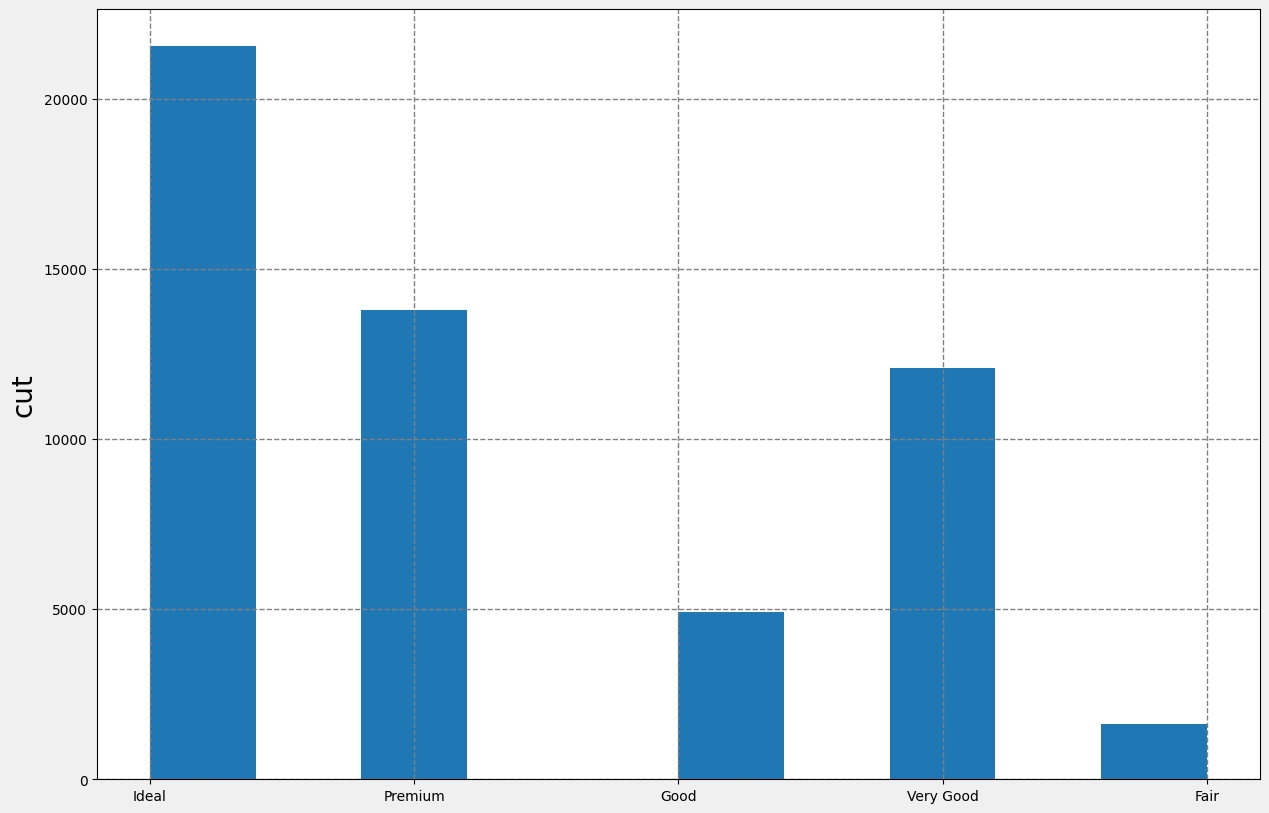

color
G   0.21
E   0.18
F   0.18
H   0.15
D   0.13
I   0.10
J   0.05
Name: proportion, dtype: float64

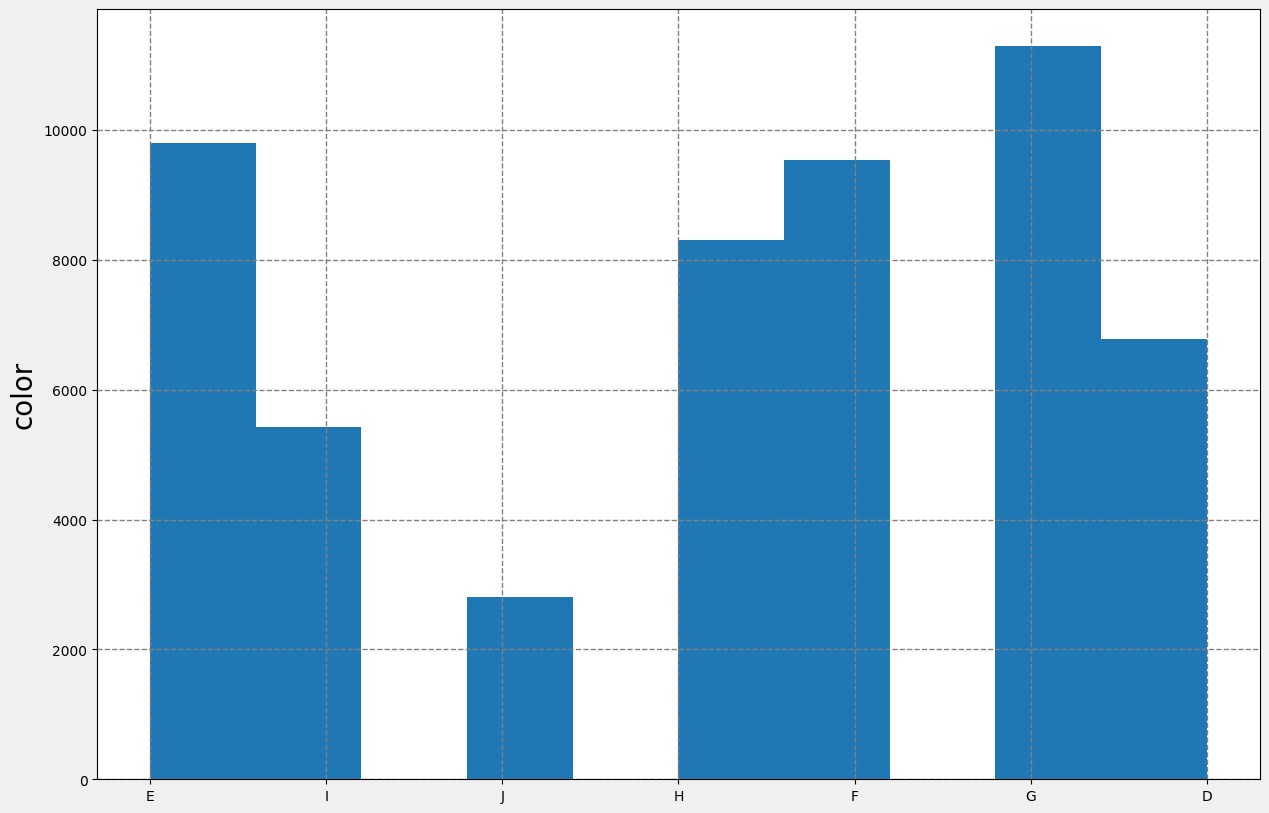

clarity
SI1    0.24
VS2    0.23
SI2    0.17
VS1    0.15
VVS2   0.09
VVS1   0.07
IF     0.03
I1     0.01
Name: proportion, dtype: float64

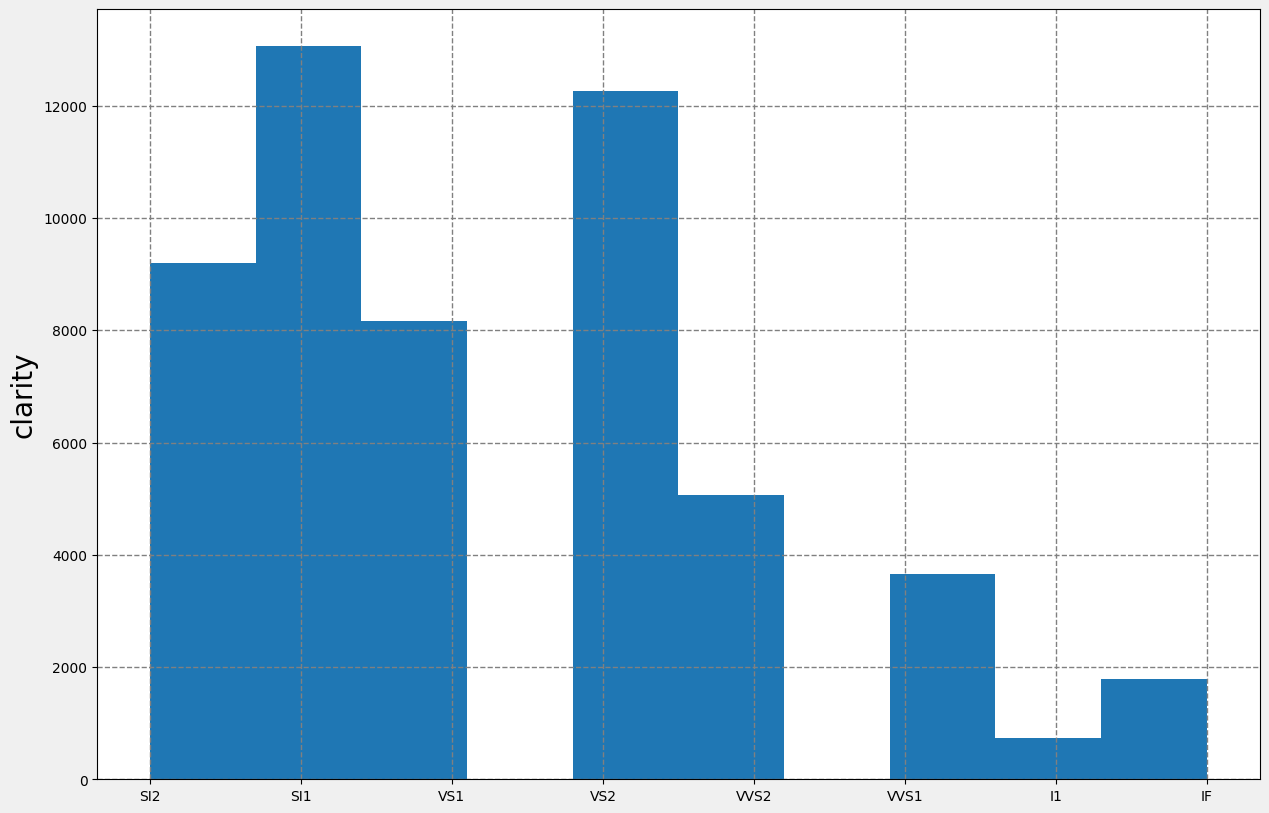

In [5]:
# Визуализируем респределение датасета по категориальным переменным

for column in df.columns:
    if df[column].dtype == 'object':
        display(df[column].value_counts(normalize=True))
        plt.figure(figsize=(15, 10), facecolor='#f0f0f0')
        plt.hist(df[column])
        plt.ylabel(column, fontsize = 20)
        plt.grid(color='gray', linestyle='--', linewidth=1)
        plt.show()
        

array([[<Axes: title={'center': 'carat'}>,
        <Axes: title={'center': 'depth'}>,
        <Axes: title={'center': 'table'}>],
       [<Axes: title={'center': 'price'}>, <Axes: title={'center': 'x'}>,
        <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >, <Axes: >]], dtype=object)

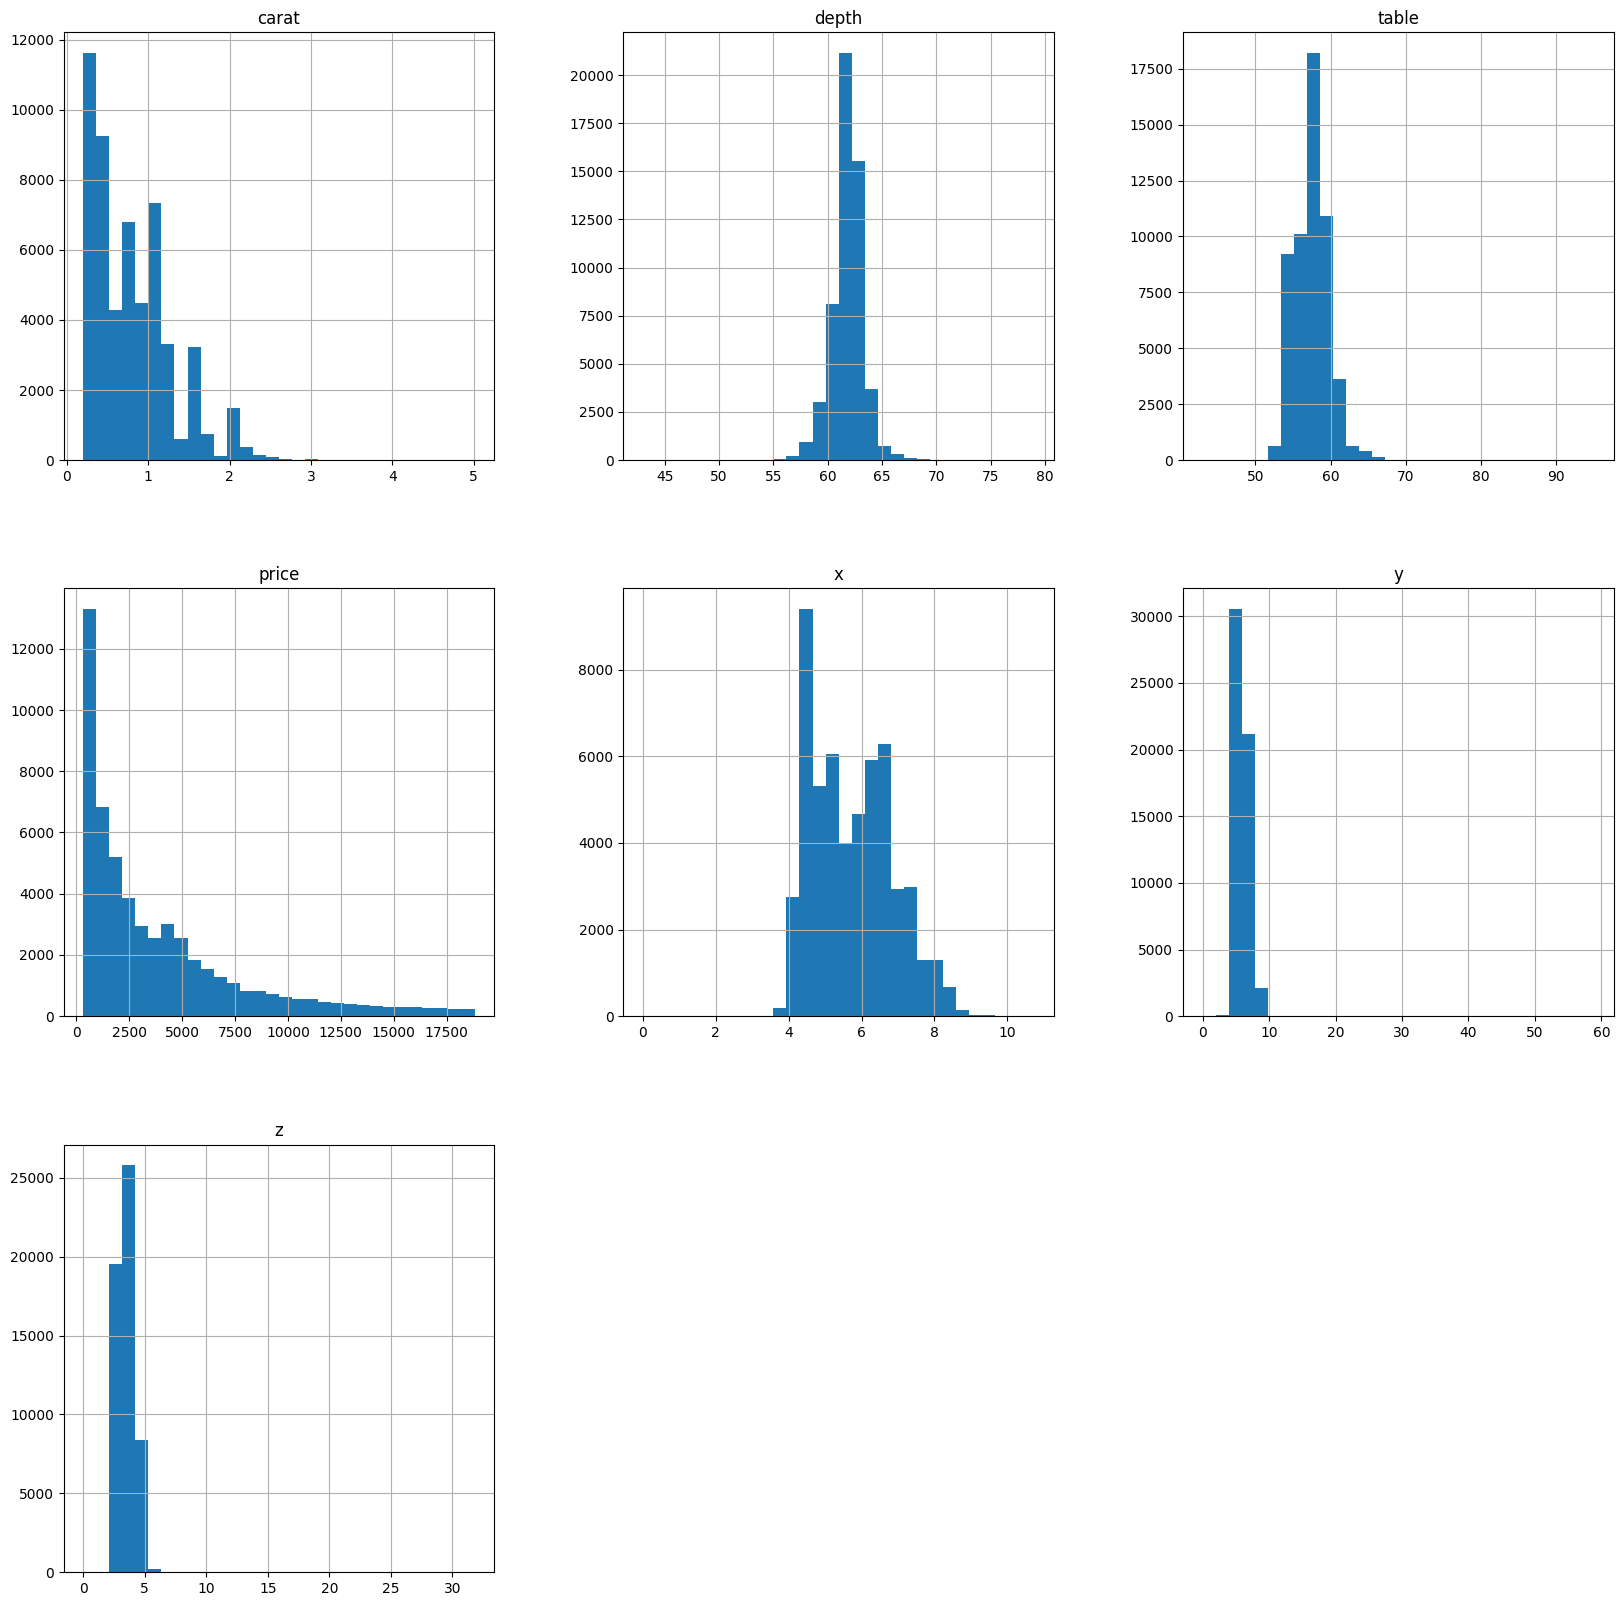

In [6]:
df.hist(figsize=(20, 20), bins = 30)

Видно сильное смещение в сторону более дешёвых бриллиантов с малым весом (количеством карат). Уже на этом этапе можно предположить из вида графиков, что 'carat' коррелирует с 'price'.

In [7]:
# Вернёмся к описанию
df.describe()

,carat,depth,table,price,x,y,z
count,53940.00,53940.00,53940.00,53940.00,53940.00,53940.00,53940.00
mean,0.80,61.75,57.46,3932.80,5.73,5.73,3.54
std,0.47,1.43,2.23,3989.44,1.12,1.14,0.71
min,0.20,43.00,43.00,326.00,0.00,0.00,0.00
25%,0.40,61.00,56.00,950.00,4.71,4.72,2.91
50%,0.70,61.80,57.00,2401.00,5.70,5.71,3.53
75%,1.04,62.50,59.00,5324.25,6.54,6.54,4.04
max,5.01,79.00,95.00,18823.00,10.74,58.90,31.80


1. Соотношение медиана-среднее в колонках carat и price подтверждают наш вывод -- данные смещены в сторону более мелких и недорогих бриллиантов.
2. Мы наблюдаем, что в колонках y и z присутствуют существенные выбросы, в 10 раз превышающие средние значения.
3. В колонках x, y и z есть нули, что физчески невозможно.

In [8]:
# Построим ящики с усами для отслеживания выбросов
def display_boxplot(df, column_name):
    
    plt.figure(figsize=(10,2))
    plt.title(f'Boxplot, {column_name}')
    sns.boxplot(df[column_name], orient='h')
    plt.xlabel(column_name)
    plt.show()

def count_outliers(df, column_name):
    
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

    return outliers_count

In [9]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

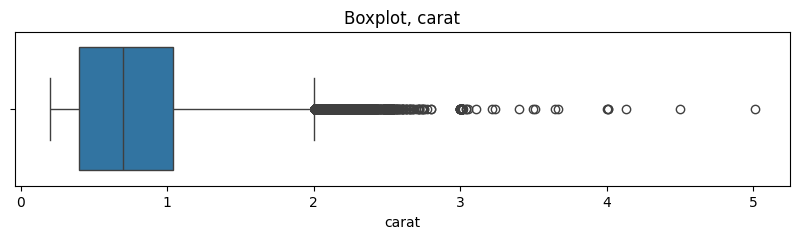

Колонка carat, количество выбросов 1889, в процентах от всего датасета 3.5%.


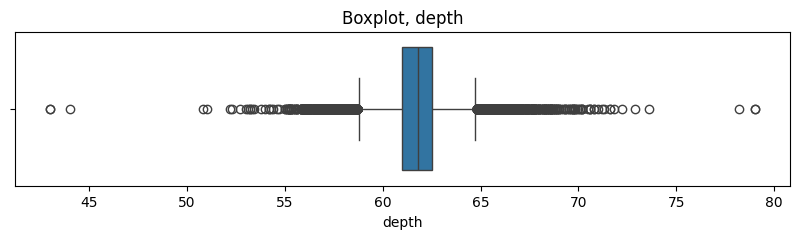

Колонка depth, количество выбросов 2545, в процентах от всего датасета 4.72%.


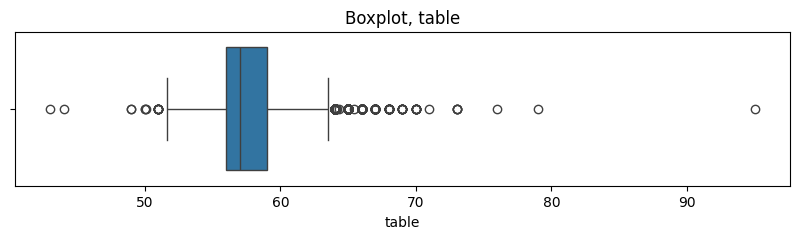

Колонка table, количество выбросов 605, в процентах от всего датасета 1.12%.


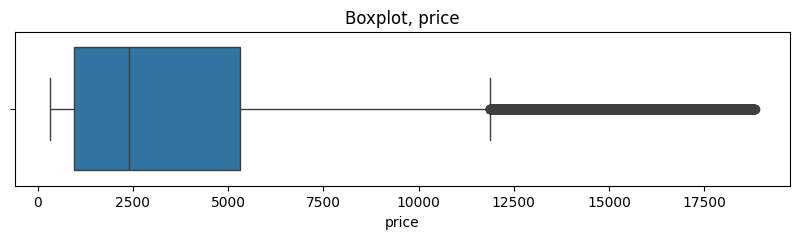

Колонка price, количество выбросов 3540, в процентах от всего датасета 6.56%.


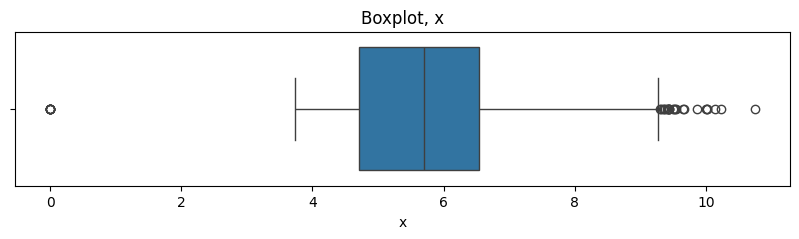

Колонка x, количество выбросов 32, в процентах от всего датасета 0.06%.


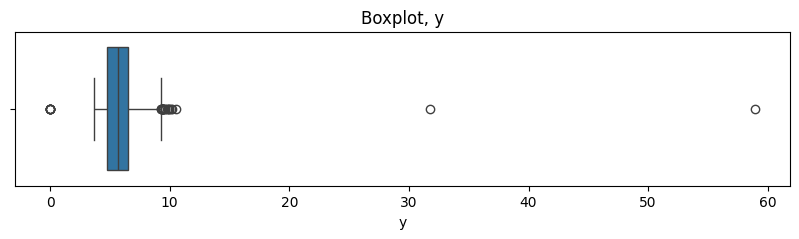

Колонка y, количество выбросов 29, в процентах от всего датасета 0.05%.


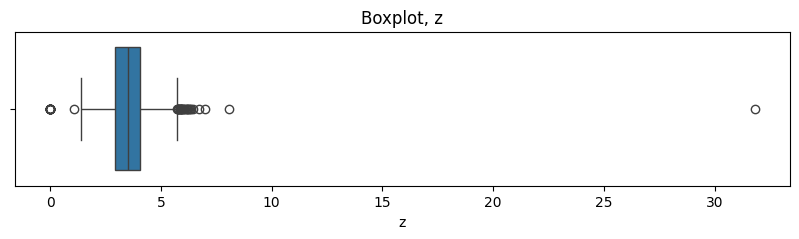

Колонка z, количество выбросов 49, в процентах от всего датасета 0.09%.


In [10]:
for column in df.columns:
    if df[column].dtype != 'object':
        display_boxplot(df, column)
        outliers = count_outliers(df, column)
        print(f'Колонка {column}, количество выбросов {outliers}, в процентах от всего датасета {round(100*outliers/df.shape[0], 2)}%.')

Выбросы по колонкам x, y и z можно удалить, они сотсавляют сотые доли процента от всего датасета.

Выбросы по колонкам price и carat более значительны 6,56% и 3,50% соответственно. Поскольку они сильно скоррелированы, эти выбросы сильно пересекаются. 

Много выбросов по колонке depth, что немного неожиданно, учитывая, что depth зависит от x, y, и z, по которым выбросов очень мало.

На первом этапе мы не будем выкидывать выбросы, будем обучать модели на всём датасете.

interval columns not set, guessing: ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']


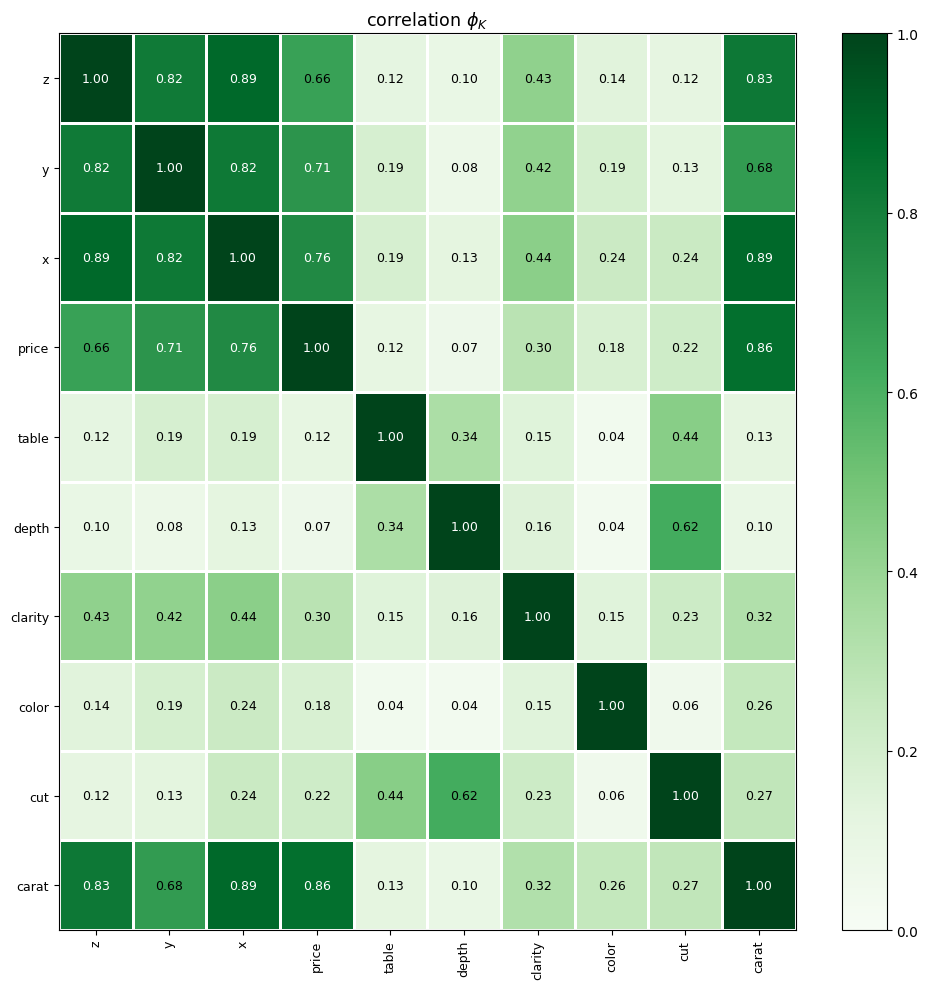

In [11]:
# Построим phik-корреляцию, чтобы понять, кто хорошо скоррелирован с таргетом, а кто друг с другом
phik_overview = df.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.9, figsize=(10, 10))
plt.tight_layout()

Мы видим, что с таргетом сильно скоррелированы фичи:
1. Carat (гипотеза подтвердилась)
2. x
3. y
4. z

И умеренно скореллирована фича clarity. Остальные скоррелированы слабо.

При этом переменные x, y, z, Carat попарно сильно скоррелированы.

Clarity так же умеренно скоррелирована с x, y, z.

In [12]:
# Предобработаем данные
# Во-первых, проверим, правильно ли составлена колонка depth
# Колонка depth, согласно описанию датасета вычисляется как depth = 2*x/(x + y) * 100%
(2*df.z/(df.x + df.y) - df.depth/100).info()
# Откуда там нули? Оказывается они есть в колонках x, y, z
display(df[(2*df.z/(df.x + df.y) - df.depth/100).isna()])

<class 'pandas.core.series.Series'>
RangeIndex: 53940 entries, 0 to 53939
Series name: None
Non-Null Count  Dtype  
--------------  -----  
53933 non-null  float64
dtypes: float64(1)
memory usage: 421.5 KB


,carat,cut,color,clarity,depth,table,price,x,y,z
11963,1.00,Very Good,H,VS2,63.30,53.00,5139,0.00,0.00,0.00
15951,1.14,Fair,G,VS1,57.50,67.00,6381,0.00,0.00,0.00
24520,1.56,Ideal,G,VS2,62.20,54.00,12800,0.00,0.00,0.00
26243,1.20,Premium,D,VVS1,62.10,59.00,15686,0.00,0.00,0.00
27429,2.25,Premium,H,SI2,62.80,59.00,18034,0.00,0.00,0.00
49556,0.71,Good,F,SI2,64.10,60.00,2130,0.00,0.00,0.00
49557,0.71,Good,F,SI2,64.10,60.00,2130,0.00,0.00,0.00


In [13]:
print(df[(df.x == 0) | (df.y == 0) | (df.z == 0)].shape[0]/df.shape[0])
print(df[(df.x == 0) | (df.y == 0) | (df.z == 0)].shape[0])
# Удалим эти значения
print(df.shape[0])
df.drop(df[(df.x == 0) | (df.y == 0) | (df.z == 0)].index, axis = 0, inplace=True)
print(df.shape[0])

df.depth = 100*2*df.z/(df.x + df.y)

0.0003707823507601038
20
53940
53920


Мы попробуем несколько моделей:

1. Линейная регрессия;
2. Решающее дерево;
3. Случайный лес;
4. Градиентный бустинг.

Оценивать модель будем с помощью метрики RMSE и сравнивать с dummy-моделью, которая выдаёт среднее значение цены на обучающем датасете.

In [14]:
# Кодируем категориальные переменные

df = pd.get_dummies(df, drop_first=True)
df = df*1
df.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.29,55.00,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.77,61.00,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.90,65.00,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.40,58.00,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.29,58.00,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


In [15]:
# Разделяем данные на фичи и таргет
features = df.drop('price', axis = 1)
target = df['price']

features_columns = features.columns

# Разделяем данные на обучающую и тестовую выборки

features, features_test, target, target_test = train_test_split(
    features, target, random_state=0, test_size=0.15)

features_train, features_val, target_train, target_val = train_test_split(
    features, target, random_state=0, test_size=0.15)

# Нормализуем данные
# scaler = StandardScaler()
# features_train = scaler.fit_transform(features_train)
# features_val = scaler.transform(features_val)
# features_test = scaler.transform(features_test)

In [16]:
# dummy-модель
dummy_price = target_train.mean()
print(f'Предсказание dummy-модели для цены: {round(dummy_price, 2)}')
print(f'RMSE dummy-модели на валидационной выборке: {root_mean_squared_error([dummy_price]*len(target_val), target_val):.2f}')
print(f'RMSE dummy-модели на тестовой выборке: {root_mean_squared_error([dummy_price]*len(target_test), target_test):.2f}')


Предсказание dummy-модели для цены: 3922.72
RMSE dummy-модели на валидационной выборке: 3968.56
RMSE dummy-модели на тестовой выборке: 4049.05


In [17]:
# Решающее дерево
model = DecisionTreeRegressor(random_state=0)
model.fit(features_train, target_train)
y_pred = model.predict(features_val)
print(f'RMSE решающего дерева на тренировочной выборке: {root_mean_squared_error(model.predict(features_train), target_train):.2f}')
print(f'RMSE решающего дерева на валидационной выборке: {root_mean_squared_error(y_pred, target_val):.2f}')

# Видим сильное переобучение решающего дерева

RMSE решающего дерева на тренировочной выборке: 8.27
RMSE решающего дерева на валидационной выборке: 820.50


In [18]:
# Случайный лес

model_tree = RandomForestRegressor(random_state=0)
model_tree.fit(features_train, target_train)
y_pred_tree = model_tree.predict(features_val)
print(f'RMSE случайного леса тренировочной выборке: {root_mean_squared_error(model_tree.predict(features_train), target_train)}')
print(f'RMSE случайного леса на валидационной выборке: {root_mean_squared_error(y_pred_tree, target_val)}')

# Метрика лучше и переобучение меньше

RMSE случайного леса тренировочной выборке: 234.79008278671765
RMSE случайного леса на валидационной выборке: 639.6973134217906


In [19]:
pd.DataFrame(zip(model_tree.feature_importances_, features_train.columns)).sort_values(by=0, ascending=False).head(5)

,0,1
4,0.47,y
0,0.42,carat
18,0.02,clarity_SI2
17,0.01,clarity_SI1
15,0.01,color_J


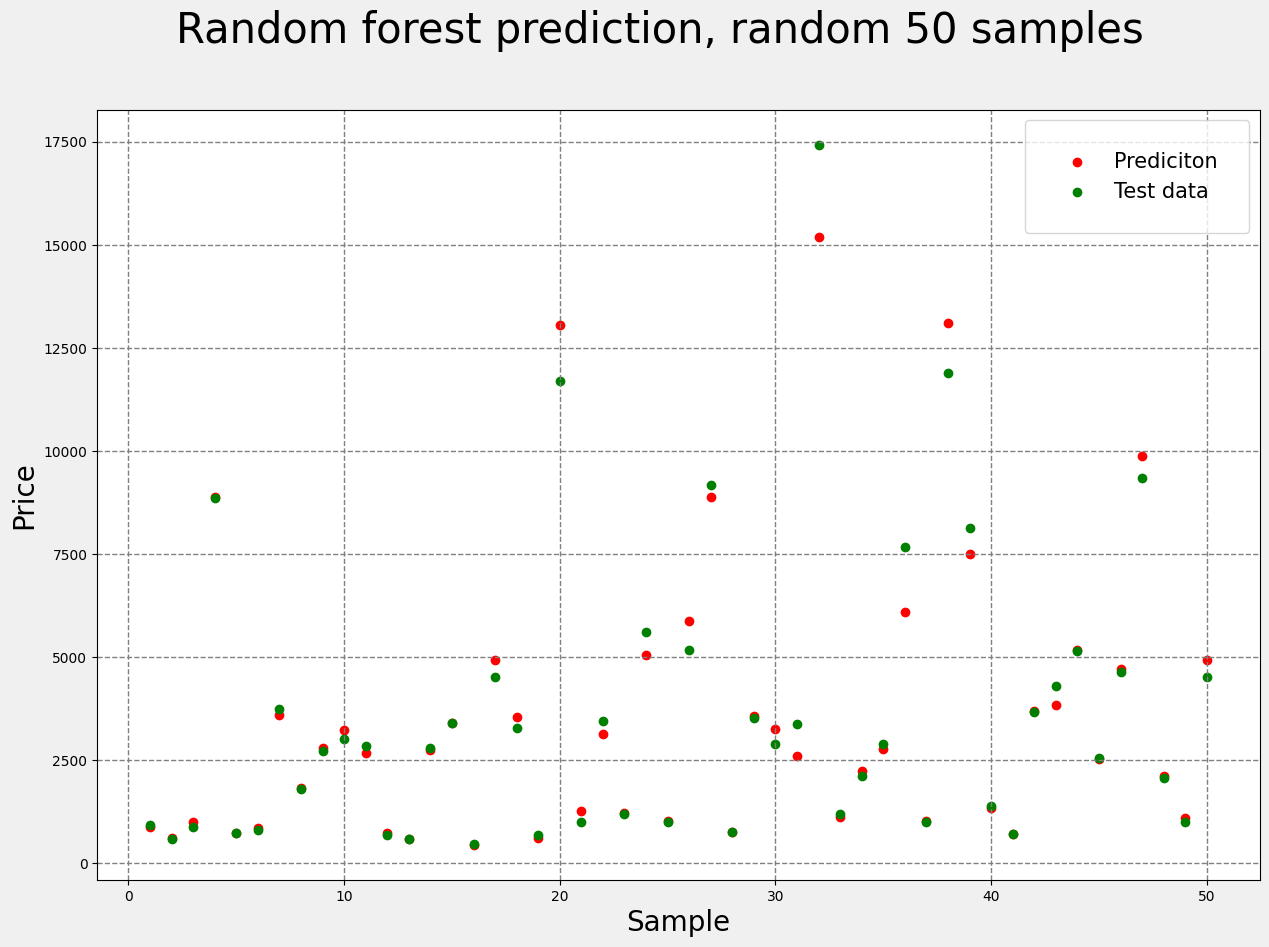

In [20]:
# Визуализируем предсказания случайного леса на случайной выборке
N = 50

random_indices = np.random.choice(len(target_val), size=N, replace=False)

plt.figure(figsize=(15, 10), facecolor='#f0f0f0')
plt.suptitle(f'Random forest prediction, random {N} samples', fontsize=30)
plt.scatter([i for i in range(1, N + 1)], y_pred_tree[random_indices]
            , c='red', label = 'Prediciton')
plt.scatter([i for i in range(1, N + 1)], target_val.to_numpy()[random_indices]
            , c='green', label = 'Test data')
plt.xlabel('Sample', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.legend(fontsize=15, borderpad=1.5)
plt.show()

In [21]:
# Градиентный бустинг
model_boost = XGBRegressor(random_state = 0)
model_boost.fit(features_train, target_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [22]:
y_pred_boost = model_boost.predict(features_val)
print(f'RMSE градиентного бустинга на тренировочной выборке: {root_mean_squared_error(model_boost.predict(features_train), target_train):.2f}')
print(f'RMSE градиентного бустинга на валидационной выборке: {root_mean_squared_error(y_pred_boost, target_val):.2f}')

RMSE градиентного бустинга на тренировочной выборке: 431.76
RMSE градиентного бустинга на валидационной выборке: 595.32


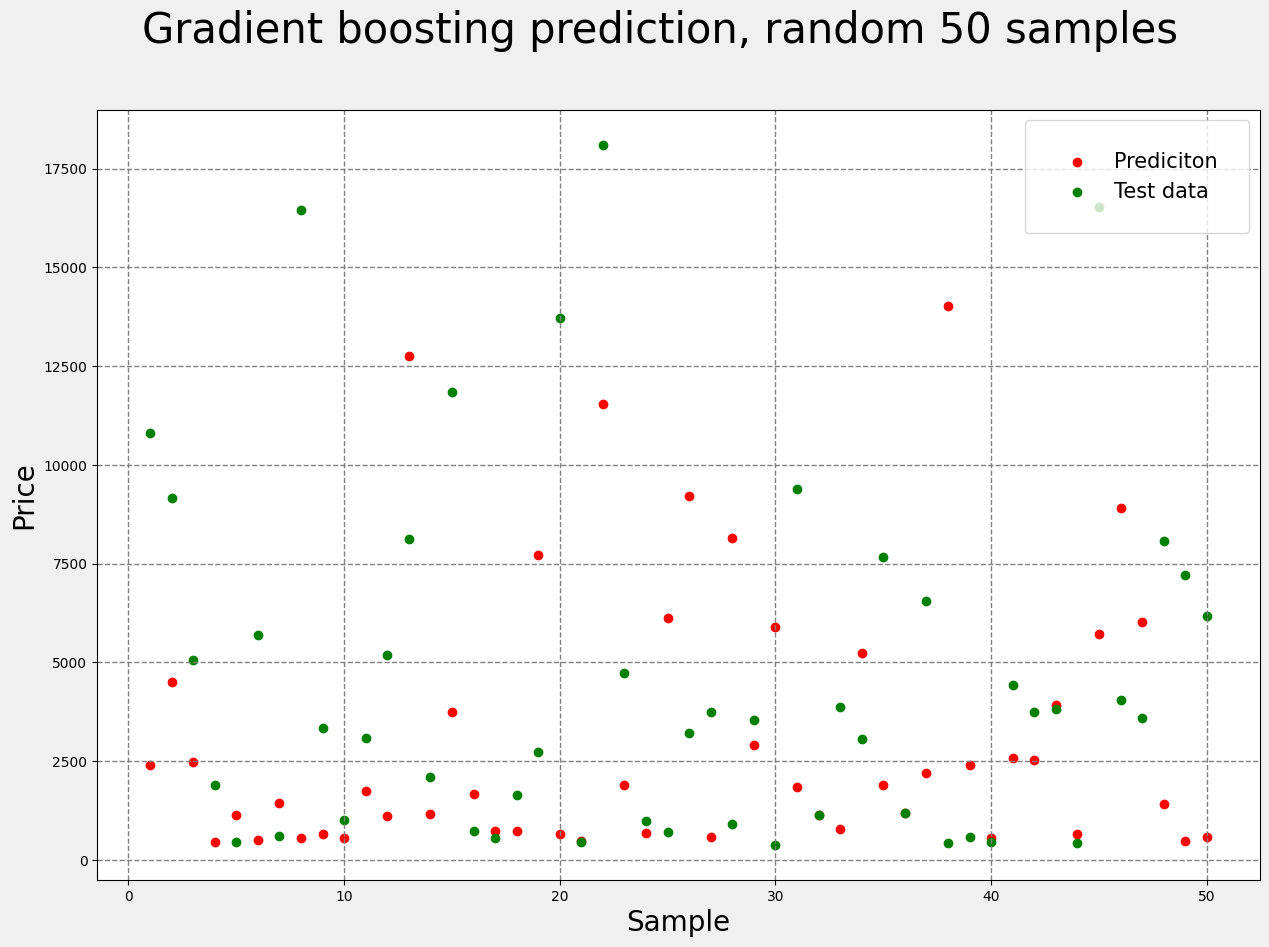

In [23]:
# Визуализируем предсказания градиентного бустинга на случайной выборке
# Видно, что модель градиентного бустинга меньше переобучается и показывает лучшую метрику, чем случайный лес
N = 50

random_indices = np.random.choice(len(target_val), size=N, replace=False)

plt.figure(figsize=(15, 10), facecolor='#f0f0f0')
plt.suptitle(f'Gradient boosting prediction, random {N} samples', fontsize=30)
plt.scatter([i for i in range(1, N + 1)], y_pred_boost[random_indices]
            , c='red', label = 'Prediciton')
plt.scatter([i for i in range(1, N + 1)], target_test.to_numpy()[random_indices]
            , c='green', label = 'Test data')
plt.xlabel('Sample', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.legend(fontsize=15, borderpad=1.5)
plt.show()

In [24]:
# Линейная регрессия
# Перед использованием линейной модели надо предобработать данные с учётом матрицы корреляций

scaler = StandardScaler()

features_train_norm = scaler.fit_transform(features_train)
features_val_norm = scaler.transform(features_val)

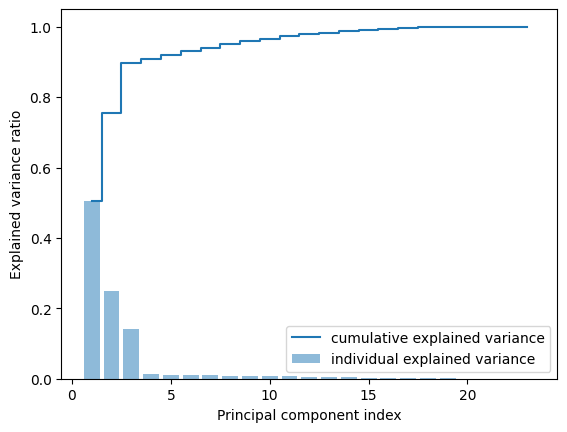

In [25]:
n = features_train.shape[1]

pca = PCA(n_components = n)
pca.fit(features_train)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, features_train.shape[1] + 1), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1, features_train.shape[1] + 1), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [26]:
pca = PCA(n_components=3)
features_train_reduced = pd.DataFrame(pca.fit_transform(features_train_norm), columns=[f'a{i}' for i in range(1, 4, 1)])
features_val_reduced = pd.DataFrame(pca.transform(features_val_norm), columns=[f'a{i}' for i in range(1, 4, 1)])

corr_matrix = features_train_reduced.corr().to_numpy()

# Посмотрим как составлены фичи

display(pd.DataFrame(pca.components_, columns = features_train.columns))

# Посмотрим на внедиагональные элементы
n = corr_matrix.shape[0]
(abs(corr_matrix) - np.eye(n)).max()

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.46,0.02,0.15,0.47,0.46,0.46,0.04,-0.15,0.10,0.02,...,0.06,0.09,0.10,-0.08,0.05,0.17,-0.04,-0.03,-0.11,-0.09
1,0.12,0.12,-0.52,0.12,0.12,0.15,-0.15,0.61,-0.38,-0.22,...,0.02,0.07,0.02,0.10,-0.10,-0.02,0.04,-0.01,0.04,0.04
2,0.01,-0.24,0.10,0.02,0.01,-0.05,-0.18,0.05,0.49,-0.44,...,-0.04,-0.04,-0.03,0.10,-0.43,0.07,0.16,0.18,0.03,0.00


3.884699966521854e-16

In [27]:
# Переобучения, конечно, нет, но метрика (в 2 раза меньше dummy-модели) довольно низкая

model_lr = LinearRegression()
model_lr.fit(features_train_reduced, target_train)
y_pred_lr = model_lr.predict(features_val_reduced)

print(f'RMSE линейной на тренировочной выборке: {root_mean_squared_error(model_lr.predict(features_train_reduced), target_train):.2f}')
print(f'RMSE линейной регрессии на валидационной выборке: {root_mean_squared_error(y_pred_lr, target_val):.2f}')

RMSE линейной на тренировочной выборке: 2003.37
RMSE линейной регрессии на валидационной выборке: 1969.49


Промежуточный вывод -- лучшей моделью для решения задачи и по метрике, и по непереобученности является градиентный бустинг. Далее мы попробуем перебрать разные параметры градиентного бустинга для потенциального улучшения метрики/качества модели.

Я сделал GridSearch, но после его выполнения VS завис и я успел сохранить только наилучшие параметры:



![Результат_GridSearch](grid.jpg)

In [28]:
model_boost_cv = XGBRegressor(n_estimators = 150, max_depth = 10, learning_rate = 0.05 , random_state = 0)
model_boost_cv.fit(features_train, target_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [29]:
print(f'RMSE дефолтного градиентного бустинга на тренировочной выборке: {root_mean_squared_error(model_boost.predict(features_train), target_train):.2f}')
print(f'RMSE дефолтного градиентного бустинга на тестовой выборке: {root_mean_squared_error(model_boost.predict(features_test), target_test):.2f}')
print('\n\n')
print(f'RMSE подобранного градиентного бустинга на тренировочной выборке: {root_mean_squared_error(model_boost_cv.predict(features_train), target_train):.2f}')
print(f'RMSE подобранного градиентного бустинга на тестовой выборке: {root_mean_squared_error(model_boost_cv.predict(features_test), target_test):.2f}')

RMSE дефолтного градиентного бустинга на тренировочной выборке: 431.76
RMSE дефолтного градиентного бустинга на тестовой выборке: 585.83



RMSE подобранного градиентного бустинга на тренировочной выборке: 347.88
RMSE подобранного градиентного бустинга на тестовой выборке: 572.54


У второй модели лучше метрика, но хуже с переобученностью. Я сохраню обе модели.

Для этой задачи нужно использовать машинное обучение и нельзя обойтись dummy-предсказанием. RMSE dummy-предсказания на тестовой выборке равно 4049.05, при среднем значении цены в тестовой выборке в 3977,75 И медианном 2408.0 является неприемлемым.

RMSE градиентного бустинга при это (~580) является куда более точным.

In [30]:
with open('Model_1.pk', 'wb') as file:
    pickle.dump(model_boost, file)

with open('Model_2.pk', 'wb') as file:
    pickle.dump(model_boost_cv, file)

In [31]:
class Diamond_DS_Encoder(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.depth = 100*2*X.z/(X.x + X.y)
        X = pd.get_dummies(X, drop_first=True)
        X = X*1
        return X

In [32]:
# Обернём всё в единый пайплайн

pipe = Pipeline([  
    ('preprocessing', Diamond_DS_Encoder()),
    ('scaler', StandardScaler()),
    ('classify', XGBRegressor(random_state = 1))
])

In [33]:
pipe.fit(X = features_train, y = target_train)

Pipeline(steps=[('preprocessing', Diamond_DS_Encoder()),
                ('scaler', StandardScaler()),
                ('classify',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=1, ...))])

In [34]:
print(f'RMSE дефолтного градиентного бустинга на тренировочной выборке: {root_mean_squared_error(pipe.predict(features_train), target_train):.2f}')
print(f'RMSE дефолтного градиентного бустинга на тестовой выборке: {root_mean_squared_error(pipe.predict(features_test), target_test):.2f}')

RMSE дефолтного градиентного бустинга на тренировочной выборке: 431.76
RMSE дефолтного градиентного бустинга на тестовой выборке: 585.83
